In [1]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from aux_funcs import colored_line, compressed_read, logical_and, compressed_write, format_plot, add_pc_axes, format_pc_plot, make_path_if_not_exists, cum_sum, compute_cosine_sims
from nb_analysis_tools import load_hidden_and_behavior

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2.0

plt.rcParams['font.family'] = 'Helvetica Light'

color_high_reward = '#d95f02'
color_low_reward = '#1b9e77'
color_unrewarded = '#7570b3'
color_intersite = '#808080'
color_interpatch = '#b3b3b3'

odor_colors = [
    color_unrewarded,
    color_low_reward,
    color_high_reward,
]

In [17]:
dir_path = '../../results/rl_agent_outputs/he_init_vanilla_indep_test_2025-07-31_17_28_09_615835_var_noise_0.0_activity_weight_1'

In [18]:
hidden, pc_activities, all_session_data, flattened_hidden, pca = load_hidden_and_behavior(dir_path)

['00000.pkl', '00001.pkl', '00002.pkl', '00003.pkl']
00000.pkl
00001.pkl
00002.pkl
00003.pkl


In [19]:
env_idx = 0
session_data = all_session_data[env_idx]

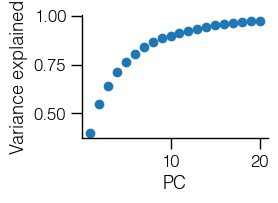

In [27]:
scale = 0.4
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

var_exp = cum_sum(pca.explained_variance_ratio_)

axs.scatter(np.arange(1, 21), var_exp[:20])
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)

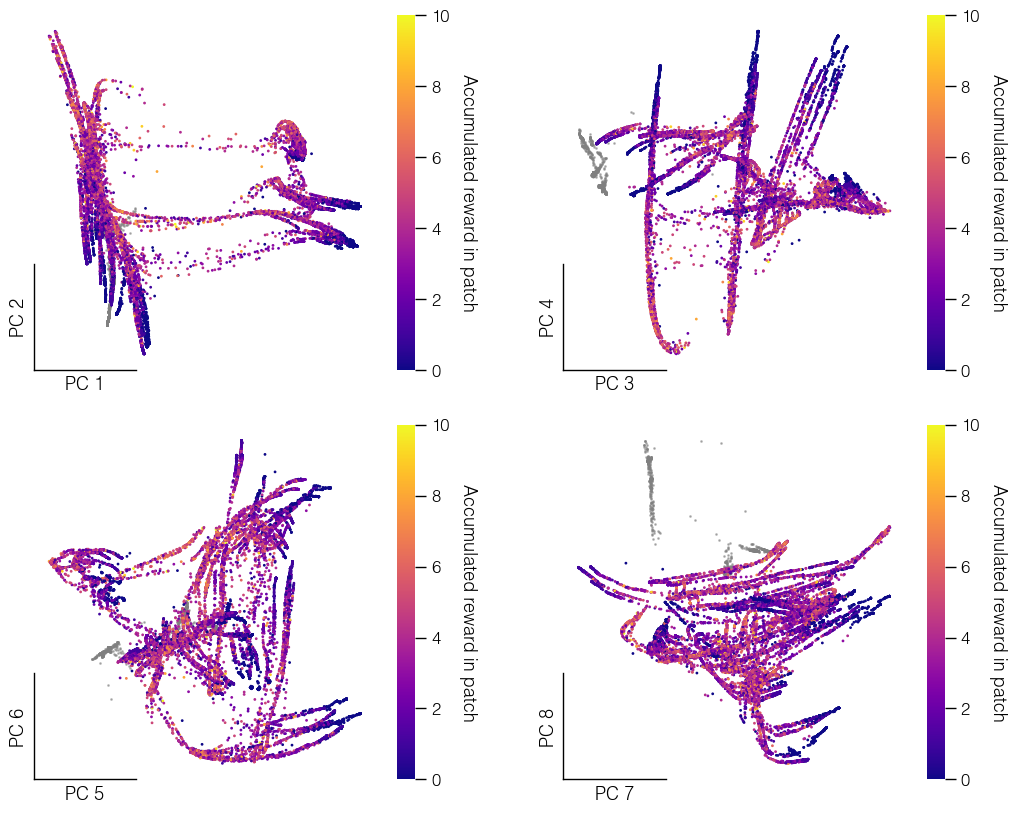

In [32]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )

    # leaving_site_mask = logical_and(
    #     session_data['agent_in_patch'] == 1,
    #     np.roll(session_data['agent_in_patch'], -1) == 0,
    # )

    # cbar = axs[k_x, k_y].scatter(
    #     pc_activities[k, env_idx, :][leaving_site_mask],
    #     pc_activities[k+1, env_idx, :][leaving_site_mask],
    #     s=1,
    #     c='red',
    #     zorder=5,
    # )

    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c=session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0],
        cmap='plasma',
        vmin=0,
        vmax=10,
    )
    cbar_ax = fig.colorbar(cbar)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Accumulated reward in patch', rotation=270, labelpad=20)
fig.tight_layout()
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
format_pc_plot(axs)

C:\Users\david.bell\AppData\Local\Temp\ipykernel_21028\1700328061.py:30: RuntimeWarning: divide by zero encountered in divide
  reward_probs = 0.8 * np.exp(-session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0] / reward_params)
C:\Users\david.bell\AppData\Local\Temp\ipykernel_21028\1700328061.py:30: RuntimeWarning: invalid value encountered in divide
  reward_probs = 0.8 * np.exp(-session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0] / reward_params)


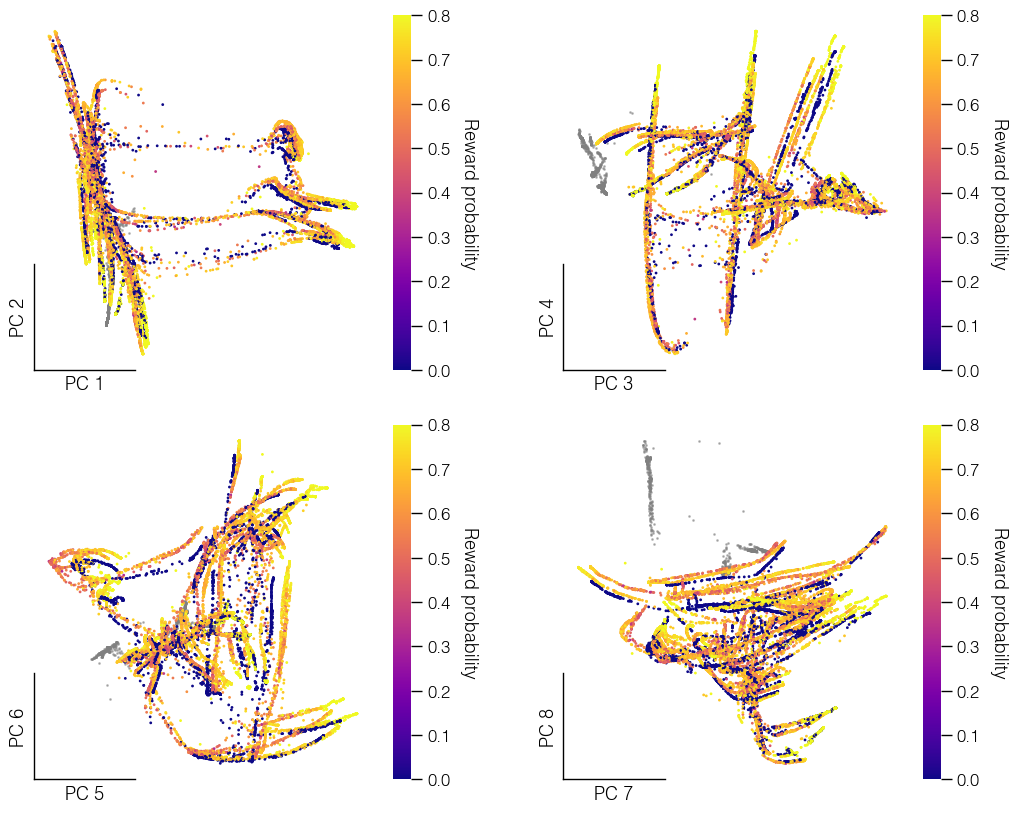

In [29]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )

    # leaving_site_mask = logical_and(
    #     session_data['agent_in_patch'] == 1,
    #     np.roll(session_data['agent_in_patch'], -1) == 0,
    # )

    # cbar = axs[k_x, k_y].scatter(
    #     pc_activities[k, env_idx, :][leaving_site_mask],
    #     pc_activities[k+1, env_idx, :][leaving_site_mask],
    #     s=1,
    #     c='green',
    #     zorder=5,
    # )

    reward_params_for_odors = np.array([0, 10, 30])
    reward_params = reward_params_for_odors[session_data['current_patch_num'][session_data['agent_in_patch'] > 0].astype(int)]
    reward_probs = 0.8 * np.exp(-session_data['rewards_seen_in_patch'][session_data['agent_in_patch'] > 0] / reward_params)
    reward_probs[session_data['current_patch_num'][session_data['agent_in_patch'] > 0] == 0] = 0

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c=reward_probs,
        cmap='plasma',
    )
    cbar_ax = fig.colorbar(cbar)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Reward probability', rotation=270, labelpad=20)
fig.tight_layout()
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
# fig.tight_layout()
format_pc_plot(axs)

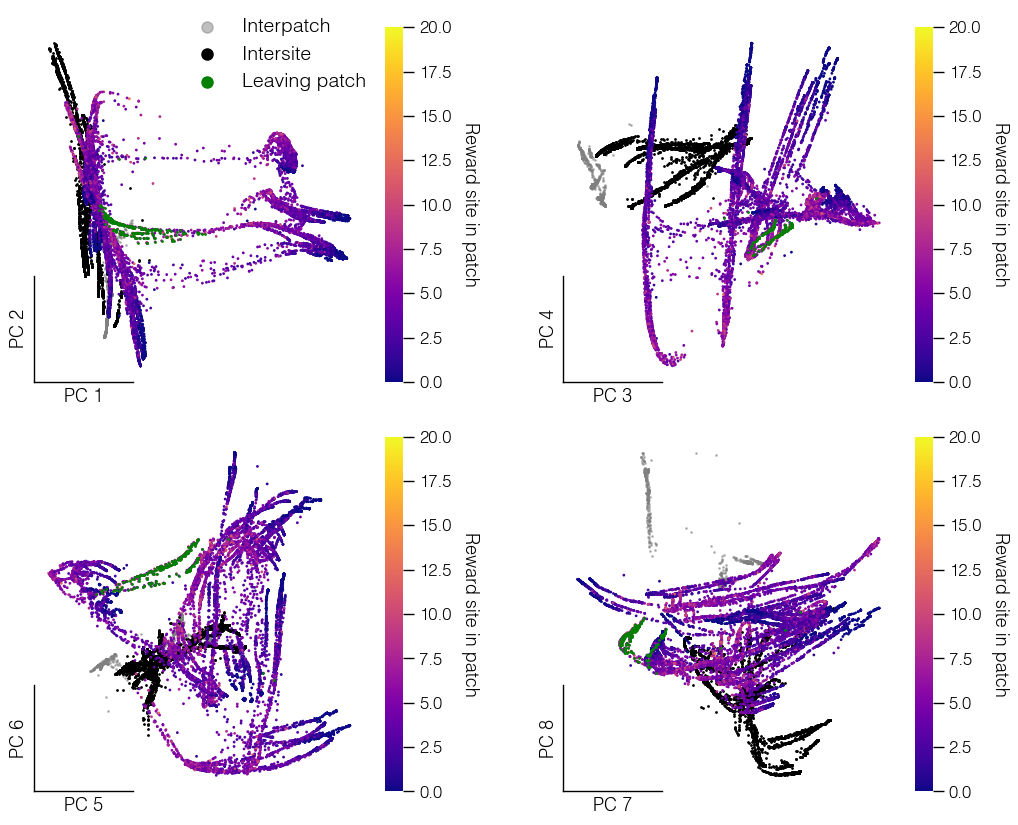

In [30]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Interpatch'
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        **extra_args,
    )

    in_patch_out_of_site_mask = logical_and(
        session_data['agent_in_patch'] > 0,
        session_data['reward_site_idx'] == -1,
    )

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Intersite'
        
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][in_patch_out_of_site_mask],
        pc_activities[k+1, env_idx, :][in_patch_out_of_site_mask],
        s=1,
        c='black',
        **extra_args,
    )

    leaving_site_mask = logical_and(
        session_data['agent_in_patch'] == 1,
        np.roll(session_data['agent_in_patch'], -1) == 0,
    )

    extra_args = {}
    if k == 0:
        extra_args['label'] = 'Leaving patch'

    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][leaving_site_mask],
        pc_activities[k+1, env_idx, :][leaving_site_mask],
        s=1,
        c='green',
        zorder=5,
        **extra_args,
    )

    in_patch_in_site_mask = logical_and(
        session_data['agent_in_patch'] > 0,
        session_data['reward_site_idx'] >= 0,
    )
    
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][in_patch_in_site_mask],
        pc_activities[k+1, env_idx, :][in_patch_in_site_mask],
        s=1,
        c=session_data['reward_site_idx'][in_patch_in_site_mask],
        cmap='plasma',
        vmin=0,
    )

    cbar_ax = fig.colorbar(cbar)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Reward site in patch', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
legend = fig.legend(markerscale=8, bbox_to_anchor=(0.4, 1), fontsize=14, frameon=False)
fig.tight_layout()
format_pc_plot(axs)
# fig.tight_layout()

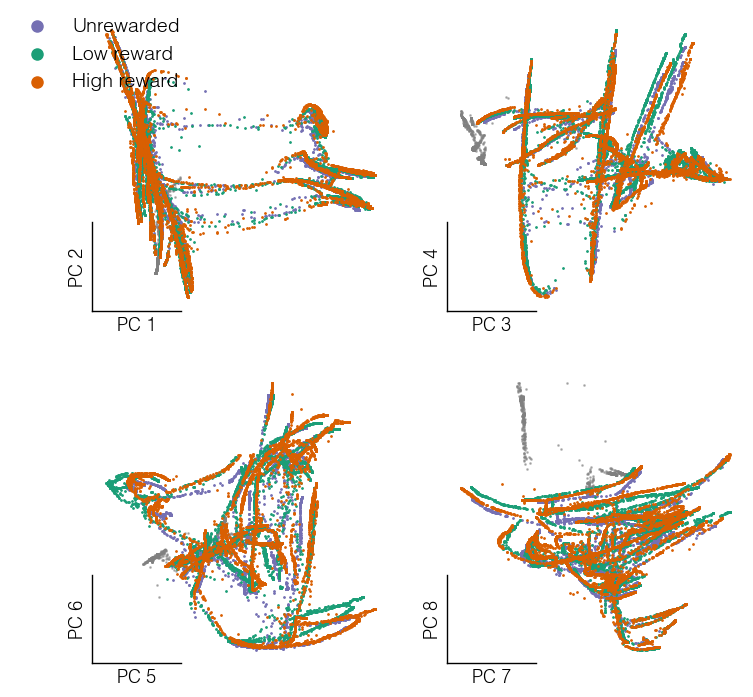

In [31]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(7 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )

    colors = odor_colors

    labels = [
        'Unrewarded',
        'Low reward',
        'High reward',
    ]
    
    for i in range(3):
        mask = logical_and(session_data['agent_in_patch'] > 0, session_data['current_patch_num'] == i)
        if k == 0:
            cbar = axs[k_x, k_y].scatter(
                pc_activities[k, env_idx, :][mask],
                pc_activities[k+1, env_idx, :][mask],
                s=1,
                color=colors[i],
                label=labels[i],
            )
        else:
            cbar = axs[k_x, k_y].scatter(
                pc_activities[k, env_idx, :][mask],
                pc_activities[k+1, env_idx, :][mask],
                s=1,
                color=colors[i],
            )
    # cbar_ax = fig.colorbar(cbar)
    # format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    # cbar_ax.outline.set_visible(False)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
legend = fig.legend(markerscale=8, bbox_to_anchor=(0.25, .9), fontsize=14, frameon=False)
# fig.tight_layout()
format_pc_plot(axs)

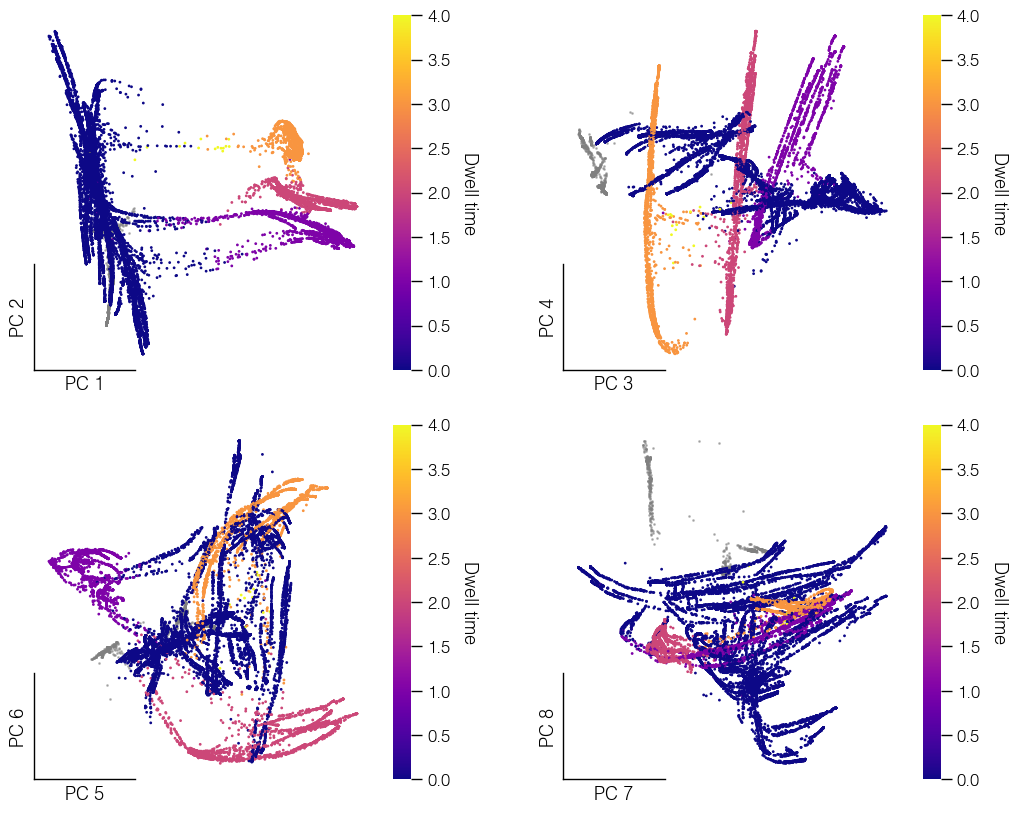

In [33]:
scale = 1.2
fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

for k in np.arange(0, 8, 2):
    k_x, k_y = int(k/4), int(k/2) % 2
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] <= 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] <= 0],
        s=1,
        c='grey',
        alpha=0.5,
        # vmax=2,
    )
    cbar = axs[k_x, k_y].scatter(
        pc_activities[k, env_idx, :][session_data['agent_in_patch'] > 0],
        pc_activities[k+1, env_idx, :][session_data['agent_in_patch'] > 0],
        s=1,
        c=session_data['dwell_time'][session_data['agent_in_patch'] > 0],
        cmap='plasma',
        vmin=0,
    )
    cbar_ax = fig.colorbar(cbar)
    format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
    cbar_ax.outline.set_visible(False)
    cbar_ax.set_label('Dwell time', rotation=270, labelpad=20)
# axs[0, 0].set_title('Activity colored by rewards seen in patch')
fig.tight_layout()
format_pc_plot(axs)